In [1]:
# Show the correlation between real and predicted tuning curves
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr
import pickle as pkl
from sklearn import linear_model  # Loss: least squares, regularization: L2
from sklearn.multioutput import MultiOutputRegressor

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
)

from functions import get_predicted_tuning_curves_one_out, get_predicted_tuning_curves_common_out

# Load the data

In [2]:
### Load all sessions ###

animal = "m135"
fov = "fov1"
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for experiment, run in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(
        animal, fov, experiment, run
    )
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

# Use the first session as the reference and then test the prediction of the common neurons with every other session

In [3]:
predicted_tuning_curves_one_out, reference_tuning_curves_one_out  = get_predicted_tuning_curves_one_out(all_tuning_curves, all_cells, sessions)

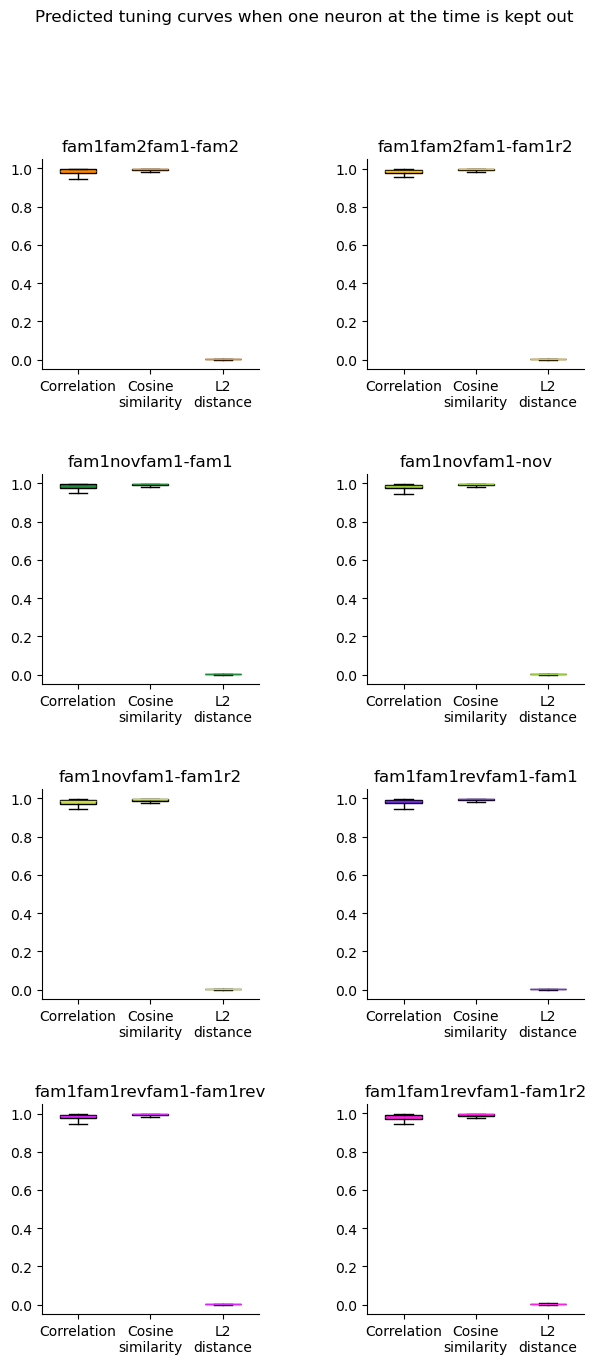

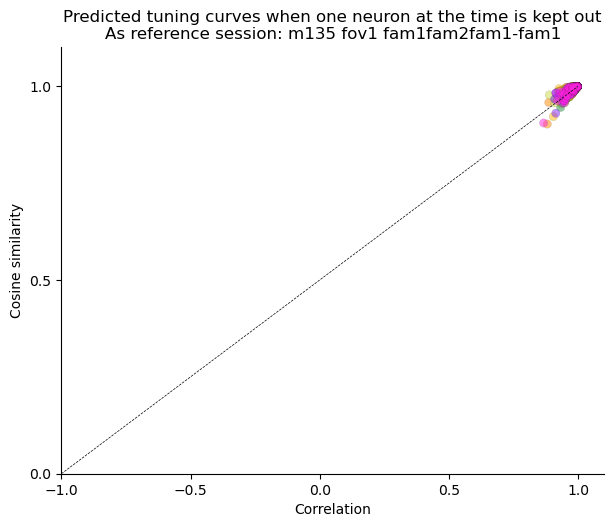

In [4]:
# Plot the difference between ref session and predicted tuning curve (while keeping the neuron out)

ref = 0

# Save the data for plotting later
all_correlations, all_cosine_similarities, all_r2 = [], [], []
assigned_colors = []
results = {}
results["ref_session"] = sessions[ref]


fig = plt.figure(figsize=(7, 15))
fig.suptitle(
    "Predicted tuning curves when one neuron at the time is kept out"
)
grid = plt.GridSpec(nrows=4, ncols=2, figure=fig, wspace=0.5, hspace=0.5)
colors = get_colors_for_each_experiment(sessions[1:])
for i, (exp, run) in enumerate(sessions[1:]):
    # Where to save the metrics for this session
    correlations_aligned, correlations_not_aligned = [], []
    cosine_similarities_aligned, cosine_similarities_not_aligned = [], []
    r2_aligned, r2_not_aligned = [], []
    for n in range(reference_tuning_curves_one_out[i].shape[1]):
        # Only if none of them is completely flat
        if (
            not np.all(
                reference_tuning_curves_one_out[i][:, n]
                == reference_tuning_curves_one_out[i][0, n]
            )
        ) and (
            not np.all(
                predicted_tuning_curves_one_out[i][:, n]
                == predicted_tuning_curves_one_out[i][0, n]
            )
        ):
            # After alignment
            correlations_aligned.append(
                pearsonr(
                    reference_tuning_curves_one_out[i][:, n],
                    predicted_tuning_curves_one_out[i][:, n],
                )[0]
            )
            cosine_similarities_aligned.append(
                np.dot(
                    reference_tuning_curves_one_out[i][:, n],
                    predicted_tuning_curves_one_out[i][:, n],
                )
                / (
                    np.linalg.norm(reference_tuning_curves_one_out[i][:, n])
                    * np.linalg.norm(predicted_tuning_curves_one_out[i][:, n])
                )
            )
            r2_aligned.append(
                np.linalg.norm(
                    reference_tuning_curves_one_out[i][:, n]
                    - predicted_tuning_curves_one_out[i][:, n]
                )
                ** 2
            )
            # Save the results
            all_correlations.append(correlations_aligned[-1])
            all_cosine_similarities.append(cosine_similarities_aligned[-1])
            all_r2.append(r2_aligned[-1])
            assigned_colors.append(colors[i])
        results[(exp, run)] = {
            "correlation": correlations_aligned,
            "cosine_similarity": cosine_similarities_aligned,
            "r2": r2_aligned,
        }

    # Plot correlation
    ax = fig.add_subplot(grid[i])
    ax.set_title(f"{exp}-{run}")
    bar_width = 0.5
    ax.boxplot(
        [correlations_aligned, cosine_similarities_aligned, r2_aligned],
        widths=bar_width,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], color="black"),
        medianprops=dict(color=colors[i]),
        whiskerprops=dict(color="black"),
    )
    ax.set_xticks([1, 2, 3], ["Correlation", "Cosine\nsimilarity", "L2\ndistance"])
    ax.spines[["right", "top"]].set_visible(False)

plt.savefig(f"{os.getcwd()}/plots/fig3c_1.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3c_1.png", dpi=300)
# Save the data
with open(
    f"{grandparent_directory}/data/fig3/fig3a/{animal}_{fov}_tc_one_neuron_kept_out.pkl",
    "wb",
) as f:
    pkl.dump(results, f)


## Plot them all together ###

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(
    all_correlations,
    all_cosine_similarities,
    color=assigned_colors,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.5,
)
ax.plot([-1, 1], [0, 1], color="black", linestyle="--", linewidth=0.5)
ax.set_xlabel("Correlation")
ax.set_ylabel("Cosine similarity")
ax.set_ylim(0, 1.1)
ax.set_xlim(-1, 1.1)
ax.set_xticks(np.arange(-1, 1.1, 0.5))
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_aspect(1.5)
ax.spines[["right", "top"]].set_visible(False)
ax.set_title(
    f"Predicted tuning curves when one neuron at the time is kept out\nAs reference session: {animal} {fov} {sessions[ref][0]}-{sessions[ref][1]}"
)
plt.show()


# Same analysis as before, but remove all the common neurons and predict them

In [3]:
results = get_predicted_tuning_curves_common_out(
    all_tuning_curves, all_cells, sessions
)

Aligning ('fam1fam2fam1', 'fam1') and ('fam1novfam1', 'fam1') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam1') and ('fam1novfam1', 'nov') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam1') and ('fam1novfam1', 'fam1r2') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam1') and ('fam1fam1revfam1', 'fam1') with 84 common neurons
Aligning ('fam1fam2fam1', 'fam1') and ('fam1fam1revfam1', 'fam1rev') with 84 common neurons
Aligning ('fam1fam2fam1', 'fam2') and ('fam1novfam1', 'fam1') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam2') and ('fam1novfam1', 'nov') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam2') and ('fam1novfam1', 'fam1r2') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam2') and ('fam1fam1revfam1', 'fam1') with 84 common neurons
Aligning ('fam1fam2fam1', 'fam2') and ('fam1fam1revfam1', 'fam1rev') with 84 common neurons
Aligning ('fam1fam2fam1', 'fam1r2') and ('fam1novfam1', 'fam1') with 106 common neurons
Aligning ('fam1fam2fam1', 'fam1r

In [ ]:
# Pl

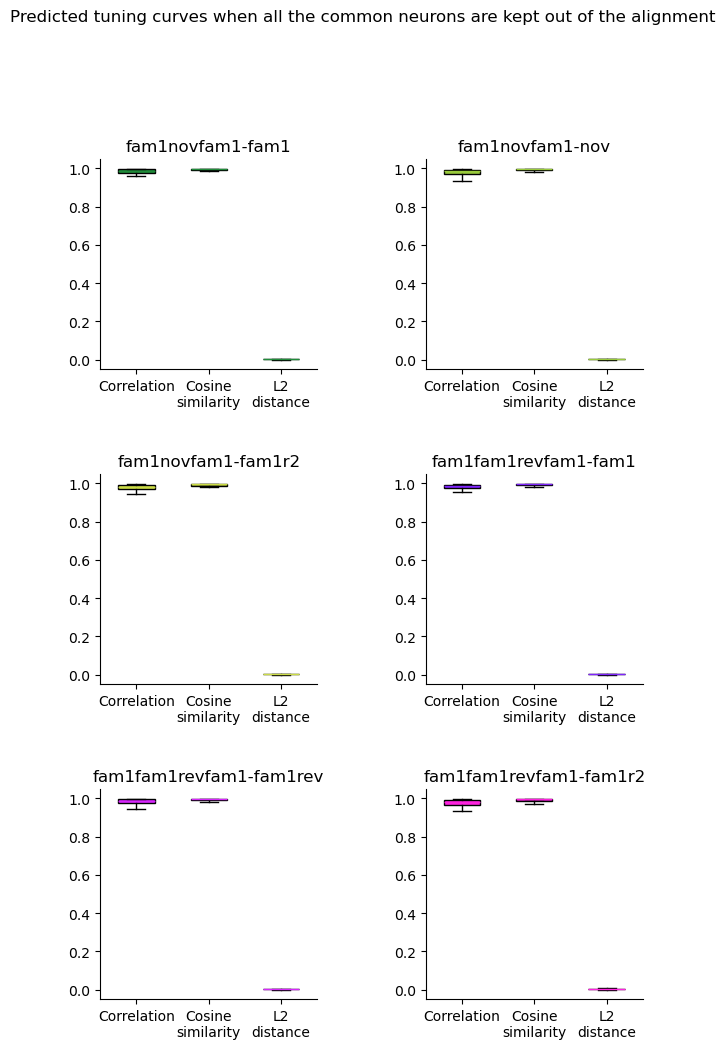

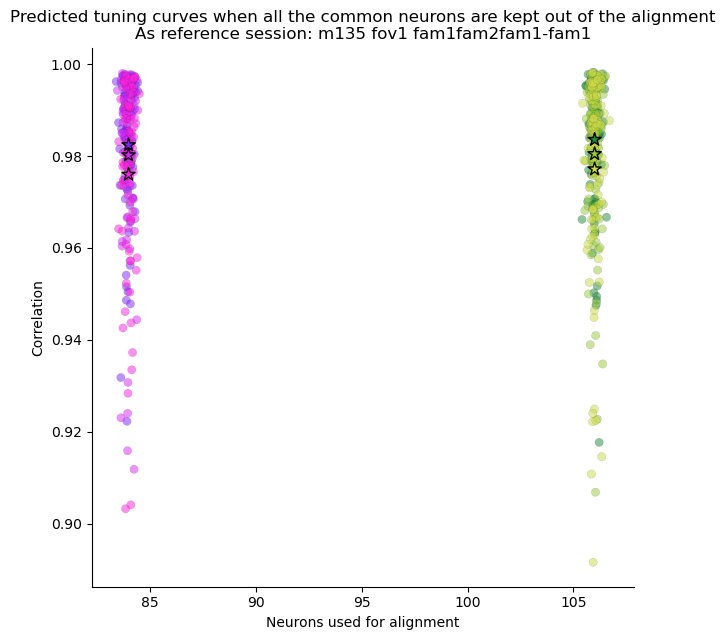

In [72]:
# Plot the difference between ref session and predicted tuning curve (while keeping the neuron out)

# Save the data for plotting later
all_correlations, all_cosine_similarities, all_r2 = [], [], []
mean_correlations = []
all_neurons_kept_out = []
assigned_colors = []
results = {}
results["ref_session"] = sessions[ref]

fig = plt.figure(figsize=(7, 15))
fig.suptitle(
    "Predicted tuning curves when all the common neurons are kept out of the alignment"
)
grid = plt.GridSpec(nrows=4, ncols=2, figure=fig, wspace=0.5, hspace=0.5)
colors = get_colors_for_each_experiment(sessions[3:])
for i, (exp, run) in enumerate(sessions[3:]):
    # Where to save the metrics for this session
    correlations_aligned = []
    cosine_similarities_aligned = []
    r2_aligned = []
    for n in range(reference_tc_kept_out[i].shape[1]):
        # Only if none of them is completely flat
        if (
            not np.all(
                reference_tc_kept_out[i][:, n]
                == reference_tc_kept_out[i][0, n]
            )
        ) and (
            not np.all(
                predicted_tc_kept_out[i][:, n]
                == predicted_tc_kept_out[i][0, n]
            )
        ):
            # After alignment
            correlations_aligned.append(
                pearsonr(
                    reference_tc_kept_out[i][:, n],
                    predicted_tc_kept_out[i][:, n],
                )[0]
            )
            cosine_similarities_aligned.append(
                np.dot(
                    reference_tc_kept_out[i][:, n],
                    predicted_tc_kept_out[i][:, n],
                )
                / (
                    np.linalg.norm(reference_tc_kept_out[i][:, n])
                    * np.linalg.norm(predicted_tc_kept_out[i][:, n])
                )
            )
            r2_aligned.append(
                np.linalg.norm(
                    reference_tc_kept_out[i][:, n]
                    - predicted_tc_kept_out[i][:, n]
                )
                ** 2
            )
            # Save the results
            all_correlations.append(correlations_aligned[-1])
            all_cosine_similarities.append(cosine_similarities_aligned[-1])
            all_r2.append(r2_aligned[-1])
            all_neurons_kept_out.append(n_neurons_kept_out[i])
            assigned_colors.append(colors[i])
        results[(exp, run)] = {
            "correlation": correlations_aligned,
            "cosine_similarity": cosine_similarities_aligned,
            "r2": r2_aligned,
        }
    mean_correlations.append(np.mean(correlations_aligned))

    # Plot correlation
    ax = fig.add_subplot(grid[i])
    ax.set_title(f"{exp}-{run}")
    bar_width = 0.5
    ax.boxplot(
        [correlations_aligned, cosine_similarities_aligned, r2_aligned],
        widths=bar_width,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], color="black"),
        medianprops=dict(color=colors[i]),
        whiskerprops=dict(color="black"),

    )
    ax.set_xticks([1, 2, 3], ["Correlation", "Cosine\nsimilarity", "L2\ndistance"])
    ax.spines[["right", "top"]].set_visible(False)

plt.savefig(f"{os.getcwd()}/plots/fig3c_2.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3c_2.png", dpi=300)
# Save the data
with open(
    f"{grandparent_directory}/data/fig3/fig3a/{animal}_{fov}_tc_common_neurons_decoded_kept_out.pkl",
    "wb",
) as f:
    pkl.dump(results, f)


## Plot them all together ###

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(
    all_neurons_kept_out+np.random.normal(0, 0.2, len(all_neurons_kept_out)),
    all_correlations,
    color=assigned_colors,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.5,
)
ax.scatter(n_neurons_kept_out, mean_correlations, color=colors, edgecolors="black", marker="*", s=100)
ax.set_xlabel("Neurons used for alignment")
ax.set_ylabel("Correlation")
ax.spines[["right", "top"]].set_visible(False)
ax.set_title(
    f"Predicted tuning curves when all the common neurons are kept out of the alignment\nAs reference session: {animal} {fov} {sessions[ref][0]}-{sessions[ref][1]}"
)
plt.show()


# Correlations when removing percentage of neurons

In [81]:
### Align the tuning curves to a reference session ###

# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 20)
    for tuning_curves in all_tuning_curves
]
# Take the first session as the reference
ref = 0
exp0, run0 = sessions[ref]
ref_tc = smoothed_tuning_curves[ref]
ref_cells = all_cells[ref]
perc_neurons_to_remove = 0.85

# align the sessions removing perc random neurons
# Make a decoder for each neuron kept out

predicted_tc_kept_out = []
reference_tc_kept_out = []
n_neurons_aligned = []
pca = PCA(n_components=20)
for i in range(len(sessions) - 1):
    print(f"Aligning session {ref} to session {i+1}\n{sessions[ref]} to {sessions[i+1]}")
    # Get the session to align to
    tuning_curves = smoothed_tuning_curves[i + 1]

    # Get indexes to remove from ref and target session
    idx_to_remove_ref = np.random.choice(ref_tc.shape[1], int(ref_tc.shape[1] * perc_neurons_to_remove), replace=False)
    idx_to_remove = np.random.choice(tuning_curves.shape[1], int(tuning_curves.shape[1] * perc_neurons_to_remove), replace=False)
    print(f"Removing {len(idx_to_remove_ref)} neurons from reference and {len(idx_to_remove)} neurons from target session")

    # Remove the neuron from the reference and target tuning curves and get their PCA
    ref_kept_out_tc = ref_tc[:, idx_to_remove_ref]  # Use for training the decoder
    sel_tc_ref = np.delete(ref_tc, idx_to_remove_ref, axis=1)
    pca_sel_tc_ref = pca.fit_transform(sel_tc_ref)

    sel_tc = np.delete(tuning_curves, idx_to_remove, axis=1)
    pca_sel_tc = pca.fit_transform(sel_tc)

    # Align the tuning curves
    A, B, _, _, _ = canoncorr(pca_sel_tc_ref, pca_sel_tc, fullReturn=True)
    # Project the target tuning curves on the reference space
    projected_pca_tc = pca_sel_tc @ B @ np.linalg.inv(A)

    # Make a decoder from reference PC space for ref_tc
    model = MultiOutputRegressor(linear_model.LinearRegression())
    model.fit(
        pca_sel_tc_ref, ref_kept_out_tc
    )
    pred_tc = model.predict(projected_pca_tc)

    predicted_tc_kept_out.append(pred_tc)
    reference_tc_kept_out.append(ref_kept_out_tc)
    n_neurons_aligned.append(tuning_curves.shape[1]-len(idx_to_remove))

Aligning session 0 to session 1
('fam1fam2fam1', 'fam1') to ('fam1fam2fam1', 'fam2')
Removing 177 neurons from reference and 177 neurons from target session
Aligning session 0 to session 2
('fam1fam2fam1', 'fam1') to ('fam1fam2fam1', 'fam1r2')
Removing 177 neurons from reference and 177 neurons from target session
Aligning session 0 to session 3
('fam1fam2fam1', 'fam1') to ('fam1novfam1', 'fam1')
Removing 177 neurons from reference and 209 neurons from target session
Aligning session 0 to session 4
('fam1fam2fam1', 'fam1') to ('fam1novfam1', 'nov')
Removing 177 neurons from reference and 209 neurons from target session
Aligning session 0 to session 5
('fam1fam2fam1', 'fam1') to ('fam1novfam1', 'fam1r2')
Removing 177 neurons from reference and 209 neurons from target session
Aligning session 0 to session 6
('fam1fam2fam1', 'fam1') to ('fam1fam1revfam1', 'fam1')
Removing 177 neurons from reference and 221 neurons from target session
Aligning session 0 to session 7
('fam1fam2fam1', 'fam1'

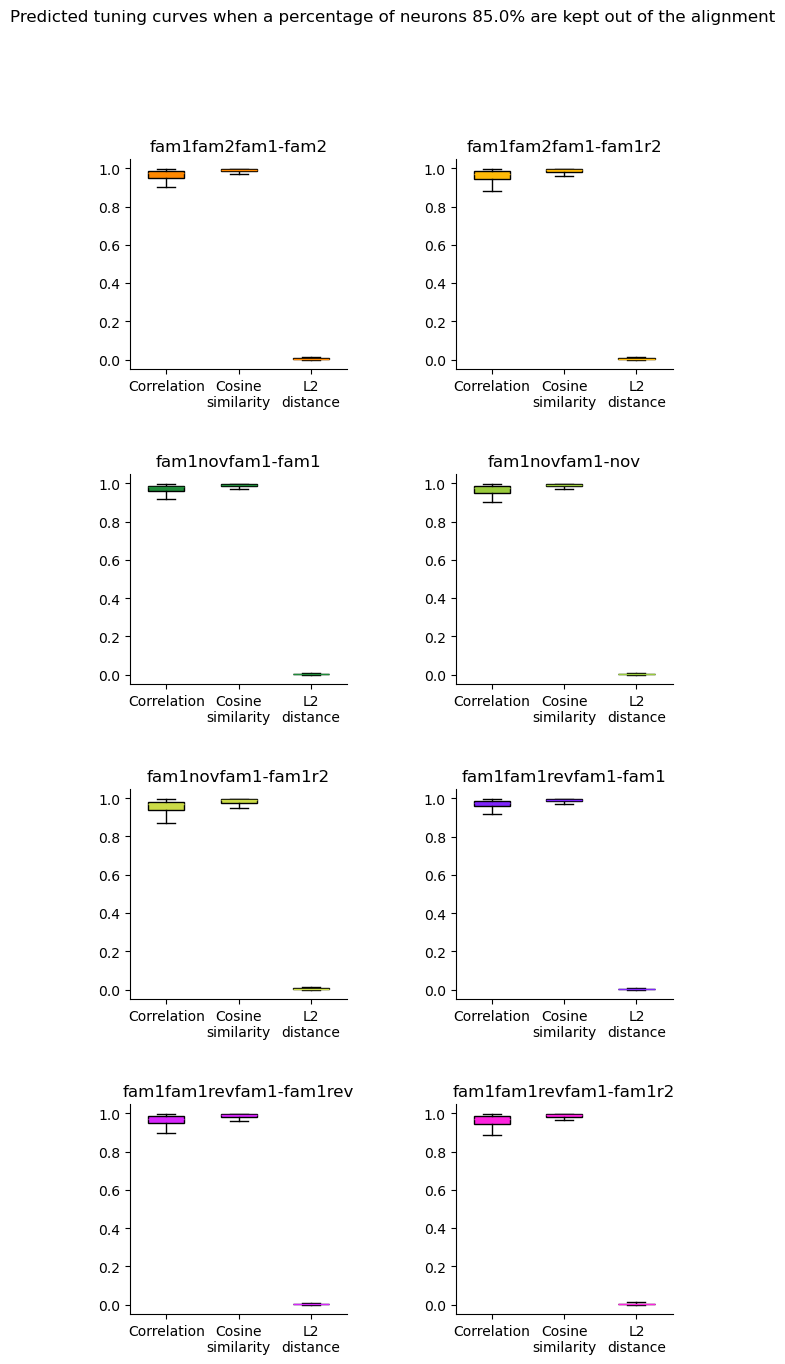

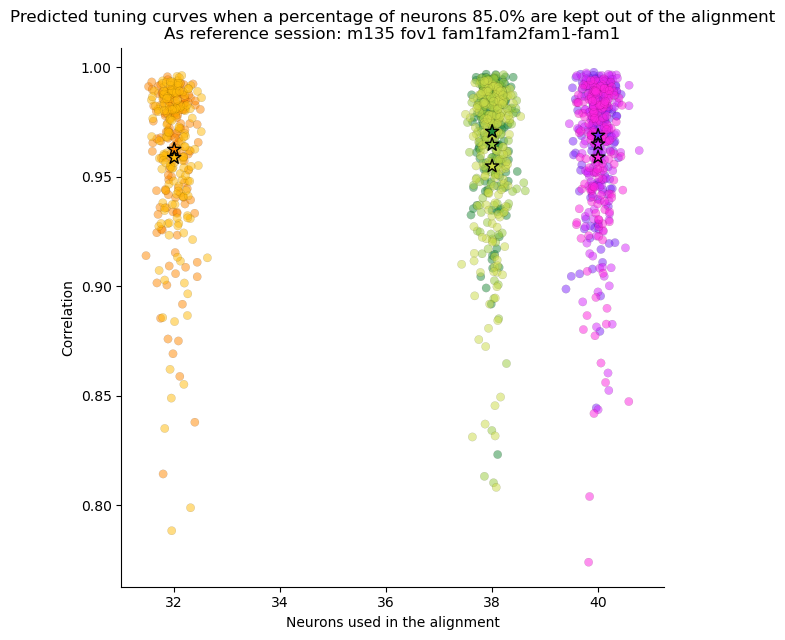

In [80]:
# Plot the difference between ref session and predicted tuning curve (while keeping the neuron out)

# Save the data for plotting later
all_correlations, all_cosine_similarities, all_r2 = [], [], []
mean_correlations = []
all_neurons_aligned = []
assigned_colors = []
results = {}
results["ref_session"] = sessions[ref]

fig = plt.figure(figsize=(7, 15))
fig.suptitle(
    f"Predicted tuning curves when a percentage of neurons {perc_neurons_to_remove*100}% are kept out of the alignment"
)
grid = plt.GridSpec(nrows=4, ncols=2, figure=fig, wspace=0.5, hspace=0.5)
colors = get_colors_for_each_experiment(sessions[1:])
for i, (exp, run) in enumerate(sessions[1:]):
    # Where to save the metrics for this session
    correlations_aligned = []
    cosine_similarities_aligned = []
    r2_aligned = []
    for n in range(reference_tc_kept_out[i].shape[1]):
        # Only if none of them is completely flat
        if (
            not np.all(
                reference_tc_kept_out[i][:, n]
                == reference_tc_kept_out[i][0, n]
            )
        ) and (
            not np.all(
                predicted_tc_kept_out[i][:, n]
                == predicted_tc_kept_out[i][0, n]
            )
        ):
            # After alignment
            correlations_aligned.append(
                pearsonr(
                    reference_tc_kept_out[i][:, n],
                    predicted_tc_kept_out[i][:, n],
                )[0]
            )
            cosine_similarities_aligned.append(
                np.dot(
                    reference_tc_kept_out[i][:, n],
                    predicted_tc_kept_out[i][:, n],
                )
                / (
                    np.linalg.norm(reference_tc_kept_out[i][:, n])
                    * np.linalg.norm(predicted_tc_kept_out[i][:, n])
                )
            )
            r2_aligned.append(
                np.linalg.norm(
                    reference_tc_kept_out[i][:, n]
                    - predicted_tc_kept_out[i][:, n]
                )
                ** 2
            )
            # Save the results
            all_correlations.append(correlations_aligned[-1])
            all_cosine_similarities.append(cosine_similarities_aligned[-1])
            all_r2.append(r2_aligned[-1])
            all_neurons_aligned.append(n_neurons_aligned[i])
            assigned_colors.append(colors[i])
        results[(exp, run)] = {
            "correlation": correlations_aligned,
            "cosine_similarity": cosine_similarities_aligned,
            "r2": r2_aligned,
        }
    mean_correlations.append(np.mean(correlations_aligned))

    # Plot correlation
    ax = fig.add_subplot(grid[i])
    ax.set_title(f"{exp}-{run}")
    bar_width = 0.5
    ax.boxplot(
        [correlations_aligned, cosine_similarities_aligned, r2_aligned],
        widths=bar_width,
        showfliers=False,
        patch_artist=True,
        boxprops=dict(facecolor=colors[i], color="black"),
        medianprops=dict(color=colors[i]),
        whiskerprops=dict(color="black"),

    )
    ax.set_xticks([1, 2, 3], ["Correlation", "Cosine\nsimilarity", "L2\ndistance"])
    ax.spines[["right", "top"]].set_visible(False)

plt.savefig(f"{os.getcwd()}/plots/fig3c_3.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3c_3.png", dpi=300)
# Save the data
with open(
    f"{grandparent_directory}/data/fig3/fig3a/{animal}_{fov}_tc_common_neurons_decoded_kept_out.pkl",
    "wb",
) as f:
    pkl.dump(results, f)


## Plot them all together ###

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.scatter(
    all_neurons_aligned + np.random.normal(0, 0.2, len(all_neurons_aligned)),
    all_correlations,
    color=assigned_colors,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.5,
)
ax.scatter(n_neurons_aligned, mean_correlations, color=colors, edgecolors="black", marker="*", s=100)
ax.set_xlabel("Neurons used in the alignment")
ax.set_ylabel("Correlation")
ax.spines[["right", "top"]].set_visible(False)
ax.set_title(
    f"Predicted tuning curves when a percentage of neurons {perc_neurons_to_remove*100}% are kept out of the alignment\nAs reference session: {animal} {fov} {sessions[ref][0]}-{sessions[ref][1]}"
)
plt.savefig(f"{os.getcwd()}/plots/fig3c_4.pdf")
plt.savefig(f"{os.getcwd()}/plots/PNGs/fig3c_4.png", dpi=300)

plt.show()


# Try to predict tuning curves from neurons instead of PCs when removing 85% of neurons